# 딥드림 (DeepDream)

본 튜토리얼은 Alexander Mordvintsev가 이 [블로그 포스트](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)에서 설명한 딥드림의 간단한 구현 방법에 대해 소개합니다.

딥드림은 신경망이 학습한 패턴을 시각화하는 실험입니다. 어린 아이가 구름을 보며 임의의 모양을 상상하는 것처럼, 딥드림은 주어진 이미지 내에 있는 패턴을 향상시키고 과잉해석합니다.

이 효과는 입력 이미지를 신경망을 통해 순전파 한 후, 특정 층의 활성화값에 대한 이미지의 그래디언트(gradient)를 계산함으로써 구현할 수 있습니다. 딥드림 알고리즘은 층의 활성화값을 최대화하도록 이미지를 수정하는데, 이는 신경망으로 하여금 특정 패턴을 과잉해석 하도록 합니다. 이로써 입력 이미지를 기반으로 하는 몽환적인 이미지를 만들어낼 수 있게 됩니다. 이 과정은 [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf) 모델과 영화 [인셉션](https://en.wikipedia.org/wiki/Inception)에서 이름을 따와 "Inceptionism"이라고 부릅니다.

그럼 이제 어떻게 하면 신경망으로 하여금 이미지에 있는 초현실적인 패턴을 향상시키고 “꿈”을 꾸도록 만들 수 있는지 알아보도록 하겠습니다.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

## 변환(dream-ify)할 이미지 선택하기

이 튜토리얼에서는 [래브라도](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)의 이미지를 사용하겠습니다.

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

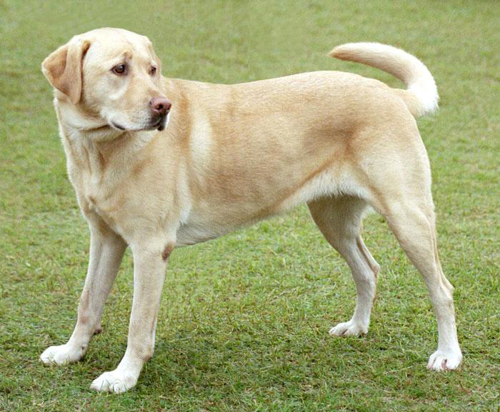

In [4]:
# 이미지를 내려받아 넘파이 배열로 변환합니다.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# 이미지를 정규화합니다.
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# 이미지를 출력합니다.
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# 이미지의 크기를 줄여 작업이 더 용이하도록 만듭니다.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## 특성 추출 모델 (feature extraction model) 준비하기

사전 훈련된 이미지 분류 모델을 내려받습니다. 본 튜토리얼에서는 딥드림에서 원래 사용된 모델과 유사한 [InceptionV3](https://keras.io/api/applications/inceptionv3/)를 사용합니다. 다른 사전 학습된 모델을 사용해도 괜찮지만, 코드 구현 시 층의 이름을 수정해야 합니다.

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [6]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

딥드림은 활성화시킬 하나 혹은 그 이상의 층을 선택한 후 "손실"을 최대화하도록 이미지를 수정함으로써 선택한 층을 "흥분"시키는 원리를 기반으로 합니다. 얼마나 복잡한 특성이 나타날지는 선택한 층에 따라 다르게 됩니다. 낮은 층을 선택한다면 획 또는 간단한 패턴이 향상되고, 깊은 층을 선택한다면 이미지 내의 복잡한 패턴이나 심지어 물체의 모습도 생성할 수 있습니다.

InceptionV3는 상당히 큰 모델입니다 (모델 구조의 그래프는 텐서플로 [연구 저장소](https://github.com/tensorflow/models/tree/master/research/slim)에서 확인할 수 있습니다). 모델의 많은 층들 중, 딥드림을 구현하기 위해 살펴보아야 할 곳은 합성곱층들이 연결된 부분입니다. InceptionV3에는 'mixed0'부터 'mixed10'까지 총 11개의 이러한 합성곱층이 있습니다. 이 중 어떤 층을 선택하느냐에 따라서 딥드림 이미지의 모습이 결정됩니다. 깊은 층은 눈이나 얼굴과 같은 고차원 특성(higher-level features)에 반응하는 반면, 낮은 층은 선분이나 모양, 질감과 같은 저차원 특성에 반응합니다. 임의의 층을 선택해 자유롭게 실험해보는 것도 가능합니다. 다만 깊은 층(인덱스가 높은 층)은 훈련을 위한 그래디언트 계산에 시간이 오래 걸릴 수 있습니다.

In [7]:
# 선택한 층들의 활성화값을 최대화합니다.
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# 특성 추출 모델을 만듭니다.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## 손실 계산하기

손실은 선택한 층들의 활성화값의 총 합으로 계산됩니다. 층의 크기와 상관 없이 모든 활성화값이 동일하게 고려될 수 있도록 각 층의 손실을 정규화합니다. 일반적으로, 손실은 경사하강법으로 최소화하고자 하는 수치입니다. 하지만 딥드림에서는 예외적으로 이 손실을 경사상승법(gradient ascent)을 통해 최대화할 것입니다.

In [8]:
def calc_loss(img, model):
  # 이미지를 순전파시켜 모델의 활성화값을 얻습니다.
  # 이미지의 배치(batch) 크기를 1로 만듭니다.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## 경사상승법

선택한 층의 손실을 구했다면, 이제 남은 순서는 입력 이미지에 대한 그래디언트를 계산하여 원본 이미지에 추가하는 것입니다.

원본 이미지에 그래디언트를 더하는 것은 신경망이 보는 이미지 내의 패턴을 향상시키는 일에 해당합니다. 훈련이 진행될수록 신경망에서 선택한 층을 더욱더 활성화시키는 이미지를 생성할 수 있습니다.

이 작업을 수행하는 아래의 함수는 성능을 최적화하기 위해 [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function)으로 감쌉니다. 이 함수는 `input_signature`를 이용해 함수가 다른 이미지 크기 혹은 `step`/`step_size`값에 대해 트레이싱(tracing)되지 않도록 합니다. 보다 자세한 설명을 위해서는 [Concrete functions guide](../../guide/function.ipynb)를 참조합니다.

In [9]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # `img`에 대한 그래디언트가 필요합니다.
          # `GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # 입력 이미지의 각 픽셀에 대한 손실 함수의 그래디언트를 계산합니다.
        gradients = tape.gradient(loss, img)

        # 그래디언트를 정규화합니다.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # 경사상승법을 이용해 "손실" 최대화함으로써 입력 이미지가 선택한 층들을 보다 더 "흥분" 시킬 수 있도록 합니다.
        # (그래디언트와 이미지의 차원이 동일하므로) 그래디언트를 이미지에 직접 더함으로써 이미지를 업데이트할 수 있습니다.
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [10]:
deepdream = DeepDream(dream_model)

## 주 루프

In [11]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # 이미지를 모델에 순전파하기 위해 uint8 형식으로 변환합니다.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

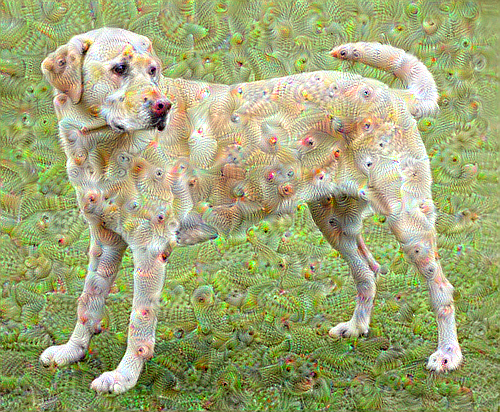

In [12]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

## 한 옥타브 (octave) 올라가기

지금 생성된 이미지도 상당히 인상적이지만, 위의 시도는 몇 가지 문제점들을 안고 있습니다:

1. 생성된 이미지에 노이즈(noise)가 많이 끼어있습니다 (이 문제는 [`tf.image.total_variation loss`](https://www.tensorflow.org/api_docs/python/tf/image/total_variation)로 해결할 수 있습니다).
2. 생성된 이미지의 해상도가 낮습니다.
3. 패턴들이 모두 균일한 입도(granularity)로 나타나고 있습니다.

이 문제들을 해결할 수 있는 한 가지 방법은 경사상승법의 스케일(scale)를 달리하여 여러 차례 적용하는 것입니다. 이는 작은 스케일에서 생성된 패턴들이 큰 스케일에서 생성된 패턴들에 녹아들어 더 많은 디테일을 형성할 수 있도록 해줍니다.

이 작업을 실행하기 위해서는 이전에 구현한 경사상승법을 사용한 후, 이미지의 크기(이를 옥타브라고 부릅니다)를 키우고 여러 옥타브에 대해 이 과정을 반복합니다.


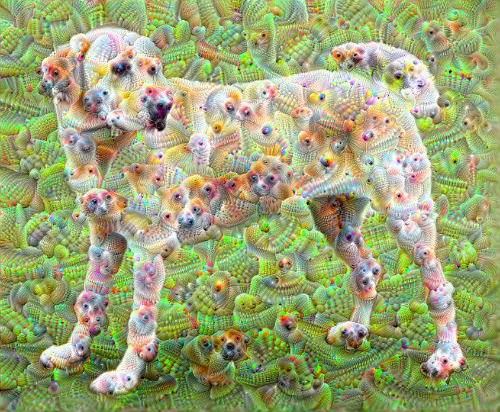

6.949268341064453

In [13]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## 선택 사항: 타일(tile)을 이용해 이미지 확장하기

한 가지 고려할 사항은 이미지의 크기가 커질수록 그래디언트 계산에 소요되는 시간과 메모리가 늘어난다는 점입니다. 따라서 위에서 구현한 방식은 옥타브 수가 많거나 입력 이미지의 해상도가 높은 상황에는 적합하지 않습니다.

입력 이미지를 여러 타일로 나눠 각 타일에 대해 그래디언트를 계산하면 이 문제를 피할 수 있습니다.

각 타일별 그래디언트를 계산하기 전에 이미지를 랜덤하게 이동하면 타일 사이의 이음새가 나타나는 것을 방지할 수 있습니다.

이미지를 랜덤하게 이동시키는 작업부터 시작합니다:

In [14]:
def random_roll(img, maxroll):
  # 타일 경계선이 생기는 것을 방지하기 위해 이미지를 랜덤하게 이동합니다.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

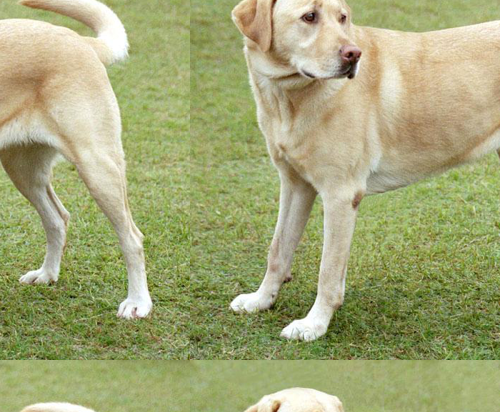

In [15]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

앞서 정의한 `deepdream` 함수에 타일 기능을 추가합니다:

In [16]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # 그래디언트를 0으로 초기화합니다.
    gradients = tf.zeros_like(img_rolled)
    
    # 타일이 하나만 있지 않은 이상 마지막 타일은 건너뜁니다.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # 해당 타일의 그래디언트를 계산합니다.
        with tf.GradientTape() as tape:
          # `img_rolled`에 대한 그래디언트를 계산합니다.
          # ‘GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img_rolled)

          # 이미지에서 타일 하나를 추출합니다.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # 해당 타일에 대한 이미지 그래디언트를 업데이트합니다.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # 이미지와 그래디언트에 적용한 랜덤 이동을 취소합니다.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # 그래디언트를 정규화합니다.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [17]:
get_tiled_gradients = TiledGradients(dream_model)

이 모든 것을 종합하면 확장 가능한 (scalabe) 옥타브 기반의 딥드림 구현이 완성됩니다:

In [18]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # 옥타브에 따라 이미지의 크기를 조정합니다.
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

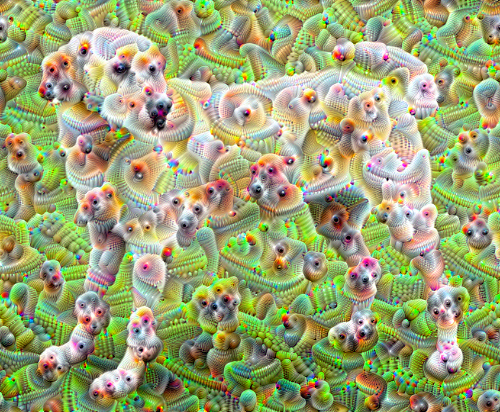

In [19]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

지금까지 본 이미지보다 더 흥미로운 결과가 생성되었습니다! 이제는 옥타브의 수, 스케일, 그리고 활성화 층을 달리해가며 어떤 딥드림 이미지를 만들 수 있는지 실험해볼 차례입니다.

이 튜토리얼에서 소개된 기법 외에 신경망의 활성화를 해석하고 시각화할 수 있는 더 많은 방법에 대해 알아보고 싶다면 [텐서플로 루시드](https://github.com/tensorflow/lucid)를 참고합니다.